In [30]:
%pylab inline
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy.integrate import simps
from scipy.optimize import curve_fit
import glob
import pandas as pd
#put your output path here
dire = '/Users/Vongolajames/Google Drive File Stream/My Drive/alcohol_martini_paper/pics'

Populating the interactive namespace from numpy and matplotlib


/miniconda3/envs/py36/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['partition']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [31]:
import re

def atoi(text):
    return int(text) if text.isdigit() else text

def natural_keys(text):
    '''
    alist.sort(key=natural_keys) sorts in human order
    http://nedbatchelder.com/blog/200712/human_sorting.html
    (See Toothy's implementation in the comments)
    '''
    return [ atoi(c) for c in re.split('(\d+)', text) ]

In [32]:
def gauss(x, *params):
    A, mu, sigma = params
    return A*np.exp(-(x-mu)**2/(2.*sigma**2))

def fitGaussian(x,y):
    # Based on http://stackoverflow.com/questions/11507028/fit-a-gaussian-function

    # obtain initial guess for Gaussian parameters

    mu = np.sum(x*y) / np.sum(y)
    sigma = np.sqrt( (np.sum(x**2*y) / np.sum(y)) - mu**2)
    dx = (np.max(x) - np.min(x)) / len(x)
    A = dx * np.sum(y) / np.sqrt(2. * np.pi * sigma**2)
    params = (A, mu, sigma)

#    print "Initial guess: A", params[0], "mu", params[1], "sigma", params[2]

    params, _ = curve_fit(gauss, x, y, p0=params)

#    print "Final guess: A", params[0], "mu", params[1], "sigma", params[2]

    return params

def computeThickness(filename, showplot=False):

    # Read in density file. Ignore lines starting with '#' or '@', which appear in output of gmx density (http://stackoverflow.com/a/24280221)
#    z,rho = np.loadtxt(filename).T
    z,rho = np.genfromtxt((r for r in open(filename) if not r[0] in ('#','@'))).T

    # divide density into two regions (z<0 and z>0), and for each fit a Gaussian, including only data points that are at least 1% of the maximal value    

    # lower leaflet peak (z<0)
    rhomax = np.max(rho[z<0])
    zlower = z[np.logical_and(z<0 , rho > 0.05 * rhomax)]
    rholower = rho[np.logical_and(z<0 , rho > 0.05 * rhomax)]
    paramslower = fitGaussian(zlower,rholower)

    # upper leaflet peak (z>0)
    rhomax = np.max(rho[z>0])
    zupper = z[np.logical_and(z>0 , rho > 0.05 * rhomax)]
    rhoupper = rho[np.logical_and(z>0 , rho > 0.05 * rhomax)]
    paramsupper = fitGaussian(zupper,rhoupper)

    if showplot:
        fig = plt.figure()
        ax = fig.add_subplot(111)

        ax.plot (z,rho, 'b.')
        zl = np.arange(np.min(zlower), np.max(zlower), 0.01)
        ax.plot (zl, gauss(zl, *paramslower), 'r-')
        zu = np.arange(np.min(zupper), np.max(zupper), 0.01)
        ax.plot (zu, gauss(zu, *paramsupper), 'g-')
        plt.show()
    
    return paramsupper[1] - paramslower[1]


# Import Data

## Get desnity profiles

In [33]:
os.chdir('/Users/Vongolajames/Downloads/alcs')
cmdline = glob.glob("*xvg")
cmdline.sort()
data = {}
for n,i in enumerate(cmdline):
    data[n] = pd.read_csv(i,header=None,index_col=None,
                     skiprows=13,delim_whitespace=True,
                     comment='@',names=['position', 'number density']
                    )

#### Get averages and errors

In [34]:
dens = {}
for n,i in enumerate(np.arange(0,len(data)-1,4)):
    dens[n] = pd.concat([pd.concat([data[i],data[i+1],data[i+2],data[i+3]]).groupby(level=0).mean(),
                      pd.concat([data[i],data[i+1],data[i+2],data[i+3]]).groupby(level=0).std()],
                      axis=1)
    dens[n].columns=['position','number density',
                    'position std','number density std']

## Get head profiles

In [35]:
os.chdir('/Users/Vongolajames/Downloads/heads')
cmdline2 = glob.glob("*xvg")
cmdline2.sort()

## Get Width profiles

In [36]:
os.chdir('/Users/Vongolajames/Downloads/widths')
cmdline3=glob.glob("*txt")
cmdline3.sort(key=natural_keys)
cmdline3=cmdline3[:-2]
cmdline3.sort()
widths=np.empty([len(cmdline3),2])
allwidths = np.empty([len(data),1]).flatten()
for n,i in enumerate(cmdline3):
    temp = pd.read_csv(i,header=None,index_col=None,
                     delim_whitespace=True,
                     comment='@',names=['width']
                    )
    widths[n][0] = temp.mean().values[0]
    widths[n][1] = temp.std().values[0]
    allwidths[n*4:n*4+4] = temp['width'].values
widths = pd.DataFrame(widths,columns = ['widths','error'])


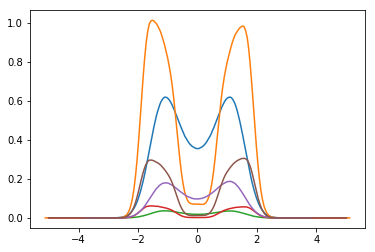

In [44]:
#quick check of density in x direction
fig = plt.figure(1)
ax = fig.add_subplot(111)
for n,i in enumerate(dens):
    if n+3+7*n > 19:
        break
    ax.plot(dens[n+2+7*n]['position'].values,
            dens[n+2+7*n]['number density'].values) 
    ax.plot(dens[n+3+7*n]['position'].values,
            dens[n+3+7*n]['number density'].values) 

In [9]:
#getting partition coefficients (w/ avg and std)
memarea,outarea,partition,logpartition=[],[],[],[]
for n,i in enumerate(data):
    inar,outar=[],[]
    left=0-allwidths[n]/2.0
    right=0+allwidths[n]/2.0
    for j in data[i].iterrows():
        if j[1][0] >= left and j[1][0] <= right:
            inar.append(j[1][:2].values)
            outar.append(np.asarray([j[1][0],0]))
        else:
            outar.append(j[1][:2].values)
            inar.append(np.asarray([j[1][0],0]))
    memarea.append(np.trapz(np.asarray(inar)[:,1],
                            np.asarray(inar)[:,0]))
    outarea.append(np.trapz(np.asarray(outar)[:,1],
                            np.asarray(outar)[:,0]))
    partition.append(memarea[n]/(outarea[n]+memarea[n]))
    logpartition.append(log(memarea[n]/outarea[n]))
p,pl=np.empty([len(cmdline3),2]), np.empty([len(cmdline3),2])
m,o=[],[]
for n,i in enumerate(p):
    p[n] = [np.mean(partition[n*4:n*4+4]),np.std(partition[n*4:n*4+4])]
    pl[n] = [np.mean(logpartition[n*4:n*4+4]),np.std(logpartition[n*4:n*4+4])]


In [10]:
#positioning partition coefficients data
x=[1,5,16]
ho,hd,bo,bd,dd,do,oo,od=[],[],[],[],[],[],[],[]
for n,i in enumerate(cmdline2):
    if 'o_ld' in i or 'o_lo' in i:
        if '_ld' in i:
            od.append(pl[n])
        else:
            oo.append(pl[n])
    if 'h_ld' in i or 'h_lo' in i:
        if '_ld' in i:
            hd.append(pl[n])
        else:
            ho.append(pl[n])
    if 'b_ld' in i or 'b_lo' in i:
        if '_ld' in i:
            bd.append(pl[n])
        else:
            bo.append(pl[n])
    if 'd_ld' in i or 'd_lo' in i:
        if '_ld' in i:
            dd.append(pl[n])
        else:
            do.append(pl[n])         
ho=roll(np.stack(ho),-1,axis=0)
hd=roll(np.stack(hd),-1,axis=0)
do=roll(np.stack(do),-1,axis=0)
dd=roll(np.stack(dd),-1,axis=0)
bo=roll(np.stack(bo),-1,axis=0)
bd=roll(np.stack(bd),-1,axis=0)
oo=roll(np.stack(oo),-1,axis=0)
od=roll(np.stack(od),-1,axis=0)


In [11]:
#positioning mem width data
x=[1,5,16]
ho_w,hd_w,bo_w,bd_w,dd_w,do_w,oo_w,od_w=[],[],[],[],[],[],[],[]
for n,i in enumerate(cmdline2):
    if 'o_ld' in i or 'o_lo' in i:
        if '_ld' in i:
            od_w.append((widths['widths'][n],widths['error'][n]))
        else:
            oo_w.append((widths['widths'][n],widths['error'][n]))
    if 'h_ld' in i or 'h_lo' in i:
        if '_ld' in i:
            hd_w.append((widths['widths'][n],widths['error'][n]))
        else:
            ho_w.append((widths['widths'][n],widths['error'][n]))
    if 'b_ld' in i or 'b_lo' in i:
        if '_ld' in i:
            bd_w.append((widths['widths'][n],widths['error'][n]))
        else:
            bo_w.append((widths['widths'][n],widths['error'][n]))
    if 'd_ld' in i or 'd_lo' in i:
        if '_ld' in i:
            dd_w.append((widths['widths'][n],widths['error'][n]))
        else:
            do_w.append((widths['widths'][n],widths['error'][n]))         
ho_w=roll(np.stack(ho_w),-1,axis=0)
hd_w=roll(np.stack(hd_w),-1,axis=0)
do_w=roll(np.stack(do_w),-1,axis=0)
dd_w=roll(np.stack(dd_w),-1,axis=0)
bo_w=roll(np.stack(bo_w),-1,axis=0)
bd_w=roll(np.stack(bd_w),-1,axis=0)
oo_w=roll(np.stack(oo_w),-1,axis=0)
od_w=roll(np.stack(od_w),-1,axis=0)


In [12]:
os.chdir('/Users/Vongolajames/Downloads/widths')
cmdline4=glob.glob("*txt")
cmdline4.sort(key=natural_keys)
cmdline4=cmdline4[-2:]
widths_control=np.empty([len(cmdline4),2])
for n,i in enumerate(cmdline4):
    temp = pd.read_csv(i,header=None,index_col=None,
                     delim_whitespace=True,
                     comment='@',names=['width']
                    )
    widths_control[n][0] = temp.mean().values[0]
    widths_control[n][1] = temp.std().values[0]
widths_control = pd.DataFrame(widths_control,columns = ['widths','error'])


In [13]:
keys=[
 'ddl-ld',
 'ddl-lo',
 'oct-ld',
 'oct-lo',
 'btl-ld',
 'btl-lo',
 'hdl-ld',
 'hdl-lo',
]
arrays=[dd_w,do_w,od_w,oo_w,bd_w,bo_w,hd_w,ho_w]
widths_dict=dict(zip(keys,arrays))
for i in widths_dict:
    if 'ld' in i:
        widths_dict[i] = (numpy.vstack((widths_control.iloc[0].values,widths_dict[i])))
    elif 'lo' in i:
        widths_dict[i] = (numpy.vstack((widths_control.iloc[1].values,widths_dict[i])))

        

In [14]:
#Sab data (from martini's python order parameter script)
pb_lo=([.701,0.704,0.698,0.692])
po_lo=([0.701,0.697,0.677,0.618])
pd_lo=([0.701,0.703,0.684,0.653])
ph_lo=([0.701,0.701,0.697,0.691])
pb_ld=([.240,0.242,0.242,0.245])
po_ld=([0.240,0.243,0.243,0.242])
pd_ld=([0.240,0.242,0.242,0.241])
ph_ld=([0.240,0.242,0.240,0.144])


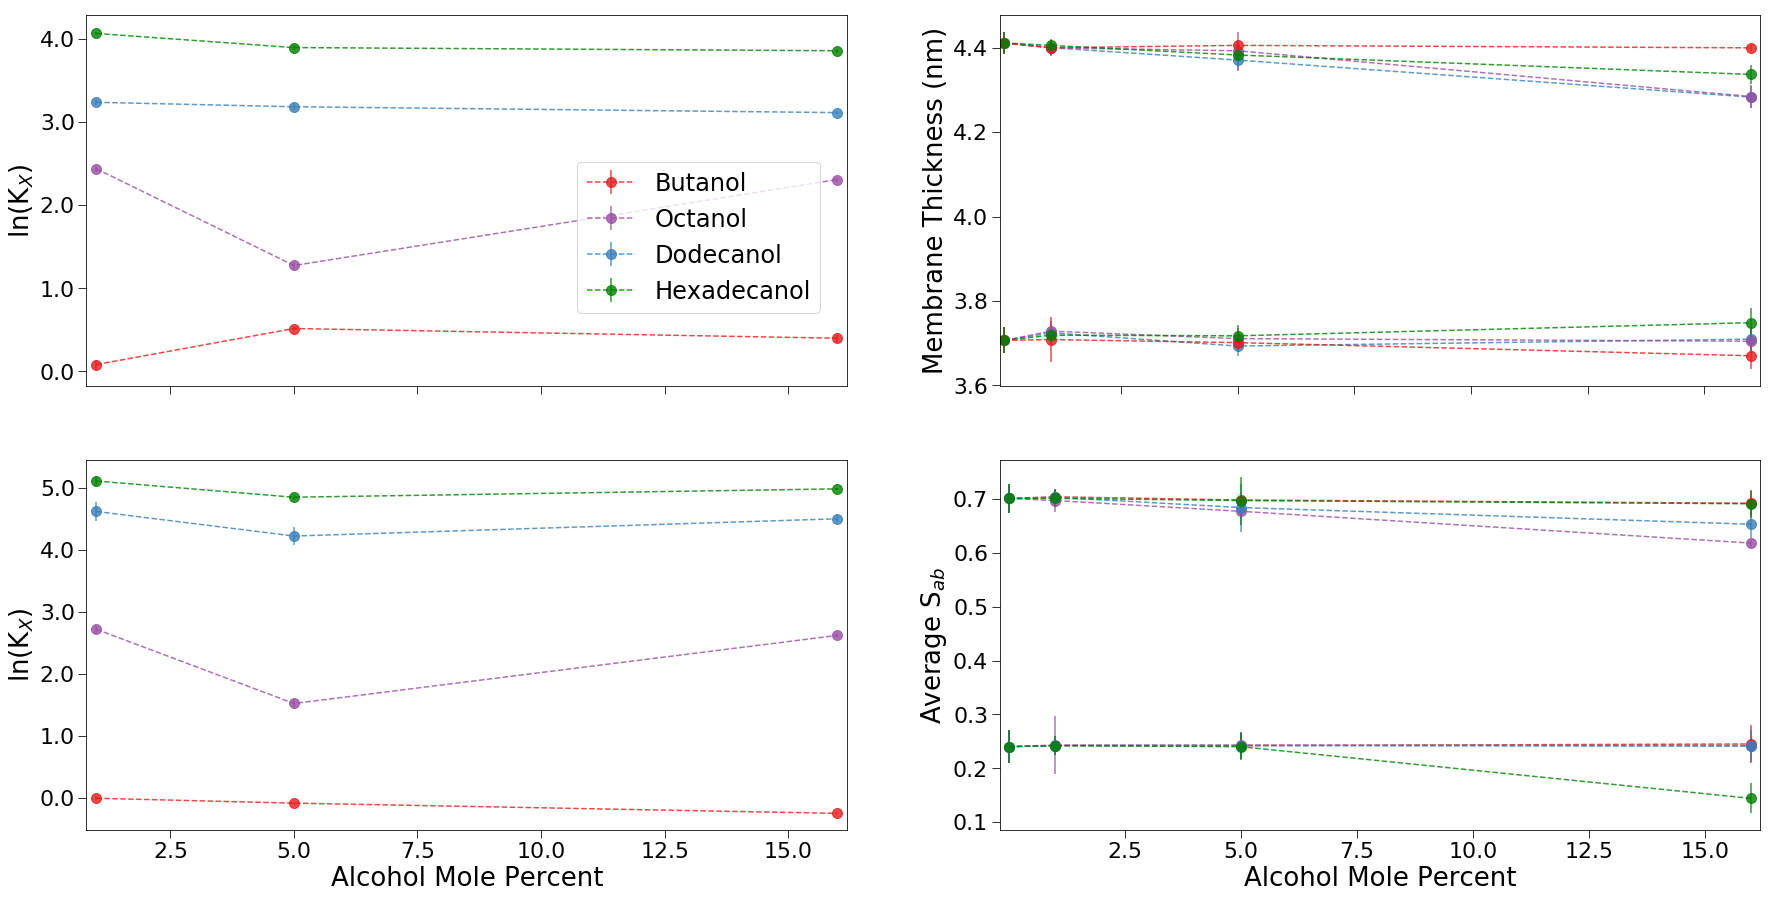

In [24]:
#plot data
fig, axs = plt.subplots(2, 2,sharey=False,sharex=False, figsize = (30, 15))
ls='--'
a=0.8
ts=26
ticksize=22
legendsize=24
x2=[0,1,5,16]
ms=20
m='.'
#Ld K

axs[0,0].errorbar(x,bd[:,0],yerr=bd[:,1],label='Butanol',alpha=a,ls=ls,color='#e41a1c',marker=m,ms=ms)
axs[0,0].errorbar(x,od[:,0],yerr=od[:,1],label='Octanol',alpha=a,ls=ls,color='#984ea3',marker=m,ms=ms)
axs[0,0].errorbar(x,dd[:,0],yerr=dd[:,1],label='Dodecanol',alpha=a,ls=ls,color='#377eb8',marker=m,ms=ms)
axs[0,0].errorbar(x,hd[:,0],yerr=hd[:,1],label='Hexadecanol',alpha=a,ls=ls,color='green',marker=m,ms=ms)
lgd=axs[0,0].legend(loc='center right',prop={'size': legendsize},bbox_to_anchor=(.98,0.4))
axs[0,0].set_ylabel(r'ln(K$_X$)',size=ts)
axs[0,0].tick_params(labelsize=ticksize)  
axs[0,0].set_xticks(np.arange(2.5,17.5,2.5))
axs[0,0].set_xlim(0.8,16.2)
axs[0,0].tick_params(labelbottom=False,length=8)
axs[0,0].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))


#Lo K
axs[1,0].errorbar(x,bo[:,0],yerr=bo[:,1],alpha=a,color='#e41a1c',marker=m,ms=ms,ls=ls)
axs[1,0].errorbar(x,oo[:,0],yerr=oo[:,1],alpha=a,color='#984ea3',marker=m,ms=ms,ls=ls)
axs[1,0].errorbar(x,do[:,0],yerr=do[:,1],alpha=a,color='#377eb8',marker=m,ms=ms,ls=ls)
axs[1,0].errorbar(x,ho[:,0],yerr=ho[:,1],alpha=a,color='green',marker=m,ms=ms,ls=ls)
axs[1,0].set_xlabel('Alcohol Mole Percent',size=ts)
axs[1,0].set_ylabel(r'ln(K$_X$)',size=ts)
axs[1,0].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
axs[1,0].tick_params(labelsize=ticksize)  
axs[1,0].set_xticks(np.arange(2.5,17.5,2.5))
axs[1,0].set_xlim(0.8,16.2)
axs[1,0].tick_params(labelbottom=True,length=8)
#Membrane Thickness
for i in widths_dict:
    if 'dd' in i:
        color = '#377eb8'
    elif 'oct' in i:
        color = '#984ea3'
    elif 'btl' in i:
        color = '#e41a1c'
    elif 'hdl' in i:
        color = 'green'
    axs[0,1].errorbar(x2,widths_dict[i][:,0],yerr=widths_dict[i][:,1],
                 alpha=a,color=color,marker=m,ms=ms,ls=ls)
axs[0,1].set_ylabel(r'Membrane Thickness (nm)',size=ts)
axs[0,1].tick_params(labelsize=ticksize)
axs[0,1].set_xticks(np.arange(2.5,17.5,2.5))
axs[0,1].tick_params(labelbottom=False,length=8)
axs[0,1].set_xlim(-0.1,16.2)

#Sab
axs[1,1].errorbar(x2,pb_lo,c='#e41a1c',yerr=widths_dict[list(widths_dict.keys())[-1]][:,1],   alpha=a,marker=m,ms=ms,ls=ls)
axs[1,1].errorbar(x2,pb_ld,c='#e41a1c',yerr=widths_dict[list(widths_dict.keys())[-2]][:,1],  alpha=a,marker=m,ms=ms,ls=ls)
axs[1,1].errorbar(x2,po_lo,c='#984ea3',yerr=widths_dict[list(widths_dict.keys())[-3]][:,1],alpha=a,marker=m,ms=ms,ls=ls)
axs[1,1].errorbar(x2,po_ld,c='#984ea3',yerr=widths_dict[list(widths_dict.keys())[-4]][:,1], alpha=a,marker=m,ms=ms,ls=ls)
axs[1,1].errorbar(x2,pd_lo,c='#377eb8',yerr=widths_dict[list(widths_dict.keys())[-5]][:,1], alpha=a,marker=m,ms=ms,ls=ls)
axs[1,1].errorbar(x2,pd_ld,c='#377eb8',yerr=widths_dict[list(widths_dict.keys())[-6]][:,1], alpha=a,marker=m,ms=ms,ls=ls)
axs[1,1].errorbar(x2,ph_lo,c='green',yerr=widths_dict[list(widths_dict.keys())[-5]][:,1], alpha=a,marker=m,ms=ms,ls=ls)
axs[1,1].errorbar(x2,ph_ld,c='green',yerr=widths_dict[list(widths_dict.keys())[-6]][:,1], alpha=a,marker=m,ms=ms,ls=ls)
axs[1,1].set_ylabel(r'Average S$_{ab}$',size=ts)
#axs[1,0].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
axs[1,1].tick_params(labelsize=ticksize)  
axs[1,1].set_xlabel('Alcohol Mole Percent',size=ts)
axs[1,1].tick_params(labelbottom=True,length=8)
axs[1,1].set_xticks(np.arange(2.5,17.5,2.5))
axs[1,1].set_xlim(-0.2,16.2)
fig.savefig('%s/fig3.png'%dire, dpi=300, bbox_inches='tight')
